<a href="https://colab.research.google.com/github/msadiq058/Lung-Cancer-Detection/blob/master/Using_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing necessary libraries**

In [ ]:
import os, shutil
from shutil import copyfile
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3

**Downloading the dataset**

In [1]:
!wget  https://www.dropbox.com/s/luhnutk30qyg3zd/LC25000.zip?dl=0

--2020-09-03 05:33:19--  https://www.dropbox.com/s/luhnutk30qyg3zd/LC25000.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/luhnutk30qyg3zd/LC25000.zip [following]
--2020-09-03 05:33:19--  https://www.dropbox.com/s/raw/luhnutk30qyg3zd/LC25000.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3d3f0d7cc536d68b9ef96cac60.dl.dropboxusercontent.com/cd/0/inline/A-qfX0fsbw05xsP6DyQ6l3U5WMGRNV1URTLZ5CmFk4q2jDeWx6VSHLgYBACC1u69KMiKB15bWrjETPHbc88D6zXwlvGVJA020cjteK3aYwM-uE0XQl1CwjSyZ47xEz-S_s0/file# [following]
--2020-09-03 05:33:19--  https://uc3d3f0d7cc536d68b9ef96cac60.dl.dropboxusercontent.com/cd/0/inline/A-qfX0fsbw05xsP6DyQ6l3U5WMGRNV1URTLZ5CmFk4q2jDeWx6VSHLgYBACC1u69KMiKB15bWrjETPHbc88D6zXwlvGVJA020cjteK3aYwM-uE0X

**Unzipping the dataset.**

In [2]:
!unzip -q LC25000.zip?dl=0

**Making directories for image processing**

In [ ]:
def make_dir():
  src = '/content/lung_model'
  os.mkdir(src)
  os.mkdir(os.path.join(src,'train'))
  os.mkdir(os.path.join(src,'val'))
  os.mkdir(os.path.join(src,'train/lung_aca'))
  os.mkdir(os.path.join(src,'train/lung_n'))
  os.mkdir(os.path.join(src,'train/lung_scc'))
  os.mkdir(os.path.join(src,'val/lung_aca'))
  os.mkdir(os.path.join(src,'val/lung_n'))
  os.mkdir(os.path.join(src,'val/lung_scc'))
make_dir()

**Function to split the dataset**

In [ ]:
def split_data(source,dest_train,dest_val,split_size):
  train_size = int(split_size *(len(os.listdir(source))))
  c = 0
  for i in os.listdir(source):
    file_path = os.path.join(source,i)
    if(c<train_size):
      dest_path = os.path.join(dest_train,i)
      copyfile(file_path,os.path.join(dest_train,i))
    else :
      dest_path = os.path.join(dest_val,i)
      copyfile(file_path,dest_path)
    c+=1

**Splitting the dataset**

In [ ]:
def call_split_data():
  
  src_lung = '/content/lung_colon_image_set/lung_image_sets'
  train_path= '/content/lung_model/train'
  val_path = '/content/lung_model/val'

  dirct = ['lung_aca','lung_n','lung_scc']
  split_size = 0.95
  for i in dirct:

    src = os.path.join(src_lung,i)
    train = os.path.join(train_path,i)
    val = os.path.join(val_path,i)

    split_data(src,train,val,split_size)


call_split_data()

**Identifying the size of directories**

In [ ]:
def print_len_dir():

  train_path= '/content/lung_model/train'
  val_path = '/content/lung_model/val'

  dirct = ['lung_aca','lung_n','lung_scc']
  for i in dirct:
    
    train = os.path.join(train_path,i)
    val = os.path.join(val_path,i)

    print(train,len(os.listdir(train)))
    print(val,len(os.listdir(val)))

print_len_dir()

/content/lung_model/train/lung_aca 4750
/content/lung_model/val/lung_aca 250
/content/lung_model/train/lung_n 4750
/content/lung_model/val/lung_n 250
/content/lung_model/train/lung_scc 4750
/content/lung_model/val/lung_scc 250


**Designing image data generator**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.0,
    horizontal_flip = True,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.1,
    fill_mode = 'nearest',
)

val_datagen = ImageDataGenerator(
    rescale = 1./255.0,
    horizontal_flip = True,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.1,
    fill_mode = 'nearest',
)

In [ ]:
target_size = (240,240)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/lung_model/train',
    target_size = target_size,
    shuffle = True,
    class_mode = 'categorical',
    batch_size  = 32
)

Found 12750 images belonging to 3 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(
    '/content/lung_model/val',
    target_size = target_size,
    batch_size = 8,
    class_mode= 'categorical',
    shuffle = True
)

Found 2250 images belonging to 3 classes.


**Designing the model**

In [ ]:
base_model = InceptionV3(include_top = False,input_shape = (240,240,3), 
                    weights = 'imagenet'
                    )

In [ ]:
print(len(base_model.layers))

311


In [ ]:
for layer in base_model.layers[:296]:
  layer.trainable = False

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 119, 119, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 119, 119, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 119, 119, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
model = Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Flatten(),
      Dense(1024,activation = 'relu'),
      Dropout(0.4),
      Dense(3,activation = 'softmax')  
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 23,904,035
Trainable params: 2,496,131
Non-trainable params: 21,407,904
____________________________________

**Model Compilation**

In [ ]:
from tensorflow.keras.optimizers import RMSprop

In [ ]:
model.compile(optimizer = RMSprop(lr = 0.0001),loss = 'categorical_crossentropy',metrics = ['acc'])

In [ ]:
file_path = '/content/drive/My Drive/Model-trained/lung_cancer'
# os.mkdir(file_path)

**Checkpoint to store the model of max validation accuracy**

In [ ]:
from tensorflow.keras.callbacks import *
filepath = os.path.join(file_path , "lung_cancer-cnn-image-aug-transfer-learn-epochs:{epoch:03d}-val_accuracy:{val_acc:.3f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = checkpoint

**Fitting the model for 10 epochs**

In [ ]:
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)
history = model.fit(train_generator,epochs = 10,steps_per_epoch=steps_per_epoch,
                    validation_data = val_generator,validation_steps = validation_steps,
                    callbacks = [callbacks_list]
                    )

Epoch 1/10
399/399 [==============================] - ETA: 0s - loss: 0.2299 - acc: 0.9071
Epoch 00001: val_acc improved from -inf to 0.96356, saving model to /content/drive/My Drive/Model-trained/lung_cancer/lung_cancer-cnn-image-aug-transfer-learn-epochs:001-val_accuracy:0.964.hdf5
399/399 [==============================] - 282s 706ms/step - loss: 0.2299 - acc: 0.9071 - val_loss: 0.0963 - val_acc: 0.9636
Epoch 2/10
399/399 [==============================] - ETA: 0s - loss: 0.1245 - acc: 0.9522
Epoch 00002: val_acc improved from 0.96356 to 0.97244, saving model to /content/drive/My Drive/Model-trained/lung_cancer/lung_cancer-cnn-image-aug-transfer-learn-epochs:002-val_accuracy:0.972.hdf5
399/399 [==============================] - 278s 698ms/step - loss: 0.1245 - acc: 0.9522 - val_loss: 0.0779 - val_acc: 0.9724
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 0.1018 - acc: 0.9617
Epoch 00003: val_acc improved from 0.97244 to 0.97644, saving model to /content/drive/

**Saving the final model and its weight for future use**

In [ ]:
model.save_weights(os.path.join(file_path,'final_weights_lung_cancer_tranfer_learning.hdf5'))
model.save(os.path.join(file_path,'model_lung_cancer_transfer_learning.h5'))

**Plotting the accuracy and loss graph**

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and validation loss')

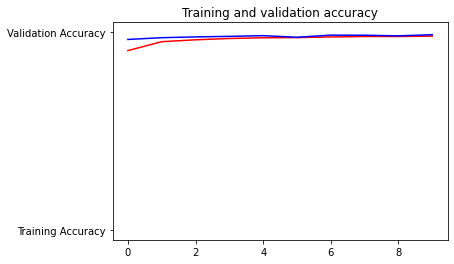

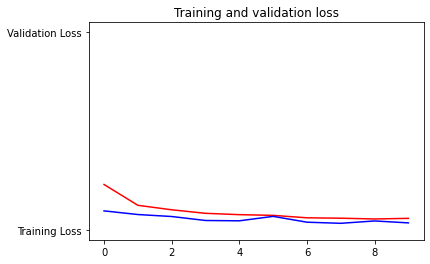

In [ ]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.title('Training and validation loss')